In [1]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import tensorflow as tf
from tensorflow.keras import layers, Sequential
import random

In [2]:
tf.test.is_built_with_cuda()

True

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

6.85e-05


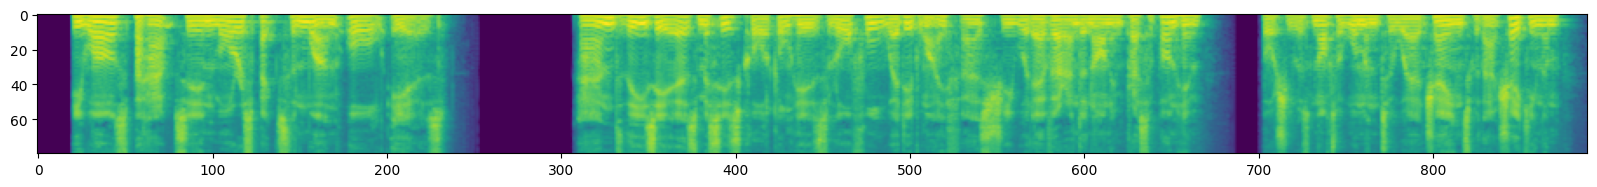

In [4]:
def show_mel_spectra(img_pth="data/train.part1/clean/31/31_121969_31-121969-0000.npy"):
    plt.figure(figsize=(20,6))
    mel_img=np.load(img_pth)
    mel_img = (mel_img-mel_img.mean()) / mel_img.std()
    plt.imshow(mel_img.astype(np.float64).T)
    print(mel_img.mean())

show_mel_spectra()

In [5]:
IMG_SHAPE = (224, 224, 3)

In [6]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers

In [7]:
class ClassificationDataGen(tf.keras.utils.Sequence):
    num_classes = 2
    clean_label = ("clean", 0) # имя класса и его численный лейбл
    noisy_label = ("noisy", 1)
    
    def __init__(self, data_folders : list,
                 batch_size,
                 input_size=IMG_SHAPE,
                 shuffle=True):

        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle

        self.file_paths = []
        for data_folder in data_folders:
            self.file_paths += glob(f"{data_folder}/clean/*/*.npy") + glob(f"{data_folder}/noisy/*/*.npy")
            random.shuffle(self.file_paths)

        self.n = len(self.file_paths)

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.file_paths)

    def __load_image(self, path, target_size):
        image_arr = np.expand_dims(np.load(path), axis=-1)
        image_arr = np.dstack([image_arr for _ in range(self.target_size[-1])])
        image_arr = tf.image.resize(image_arr,(target_size[0], target_size[1])).numpy()
        return tf.keras.utils.normalize(image_arr)

    @classmethod
    def __get_image_label(cls, path):
        label = cls.clean_label[1] if cls.clean_label[0] in path else cls.noisy_label[1]
        return tf.keras.utils.to_categorical(label, num_classes=cls.num_classes)

    def __get_data(self, file_path_batches):
        X_batch = np.asarray([self.__load_image(pth, self.input_size) for pth in file_path_batches])
        y_batch = np.asarray([self.__get_image_label(pth) for pth in file_path_batches])
        return X_batch, y_batch

    def __getitem__(self, index):
        file_path_batches = self.file_paths[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(file_path_batches)        
        return X, y

    def __len__(self):
        return self.n // self.batch_size


In [8]:
traingen = ClassificationDataGen(data_folders=["data/train.part1"], batch_size=8)
valgen = ClassificationDataGen(data_folders=["data/val"], batch_size=8)

In [9]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet',
                                               input_tensor=tf.keras.Input(shape=IMG_SHAPE))
base_model.trainable = False
# construct the head of the model that will be placed on top of the
# the base model
headModel = base_model.output
headModel = layers.Flatten(name="flatten")(headModel)
headModel = layers.Dense(512, activation="relu")(headModel)
headModel = layers.Dense(256, activation="relu")(headModel)
headModel = layers.Dense(128, activation="relu")(headModel)
headModel = layers.Dropout(0.2)(headModel)
headModel = layers.Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = tf.keras.Model(inputs=base_model.input, outputs=headModel)

base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [10]:
history = model.fit(traingen,
                    validation_data=valgen,
                    epochs=2)

Epoch 1/2
3000/3000 [==============================] - 240s 78ms/step - loss: 0.5264 - accuracy: 0.9075 - val_loss: 0.2177 - val_accuracy: 0.9498
Epoch 2/2
3000/3000 [==============================] - 236s 79ms/step - loss: 0.3602 - accuracy: 0.9301 - val_loss: 0.4118 - val_accuracy: 0.9438


In [34]:
def predict(npy_path):
    image_arr = np.expand_dims(np.load(npy_path), axis=-1)
    image_arr = np.dstack([image_arr for _ in range(IMG_SHAPE[-1])])
    image_arr = tf.image.resize(image_arr, IMG_SHAPE[:-1]).numpy()
    image_arr = tf.keras.utils.normalize(image_arr)
    print(np.argmax(model.predict(image_arr[tf.newaxis]), axis=1))
    

In [36]:
predict("data/train.part1/noisy/31/31_121969_31-121969-0000.npy")

1/1 [==============================] - 0s 32ms/step
[1]


In [ ]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()